In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from pathlib import Path
from ruamel import yaml

In [7]:
import lmfit
import h5py

from skimage.restoration import unwrap_phase

In [8]:
from scipy.optimize import brentq
from scipy.interpolate import interp1d

In [9]:
%matplotlib notebook

In [10]:
root = Path('/home/carmelo/lense_thirring/code/bh3')

In [11]:
root.exists()

True

The equation:

$$\partial_t \psi = -(i + \Lambda) (-\nabla^2 + V + \alpha |\psi|^2 - 1) \psi $$

with 

$$ V = U_0 \theta(r - R) + i\Gamma \exp(-r^2 / 2 \sigma^2) $$ 

In [12]:
def plot2d(n0, p0):
    fig, (ax, ax_p) = plt.subplots(1, 2, figsize=(18, 6))

    kk = {'ticks': None, 'orientation': 'horizontal',
          'ticklocation': 'top'}  # read this from make_axes

    c1 = ax.imshow(np.rot90(n0), extent=extent)
    cax = ax.inset_axes([0, 1.06, 1, 0.04])
    plt.colorbar(c1, cax, **kk)

    c2 = ax_p.imshow(np.rot90(p0), cmap='RdBu', extent=extent, vmin=-np.pi, vmax=np.pi)
    cax = ax_p.inset_axes([0, 1.06, 1, 0.04])
    plt.colorbar(c2, cax, **kk)

    R = abs(x.max())
    ax.set(xlabel='x', ylabel='y', xlim=(-R, R), ylim=(-R, R))
    ax_p.set(xlabel='x', ylabel='y', xlim=(-R, R), ylim=(-R, R))
    return fig, (ax, ax_p)


In [13]:
with h5py.File(root / 'build' / 'groundstate_full.h5') as f:
# with h5py.File(root / 'build' / 'imprint_pair.h5') as f:
    g = f["1"]
    t = g['t'][:]
    n = g['psiI'][:]**2 + g['psiR'][:]**2
N = n.sum((1, 2))

plt.figure()
plt.plot(t, N)

<IPython.core.display.Javascript object>

In [14]:
!ls /home/carmelo/lense_thirring/code/bh3/run/

0000  0002  0004  0006	0008  0010  0012  0014
0001  0003  0005  0007	0009  0011  0013


In [27]:

# h5filename = root / 'run/0007/bh2_0000.h5'
# h5filename = root / 'run/0009/bh_0005.h5'
h5filename = root / 'run/0014/bh_0000.h5'

h5filename = root / 'build/imprint_pair_br.h5'
# h5filename = root / 'build/groundstate.h5'

<IPython.core.display.Javascript object>


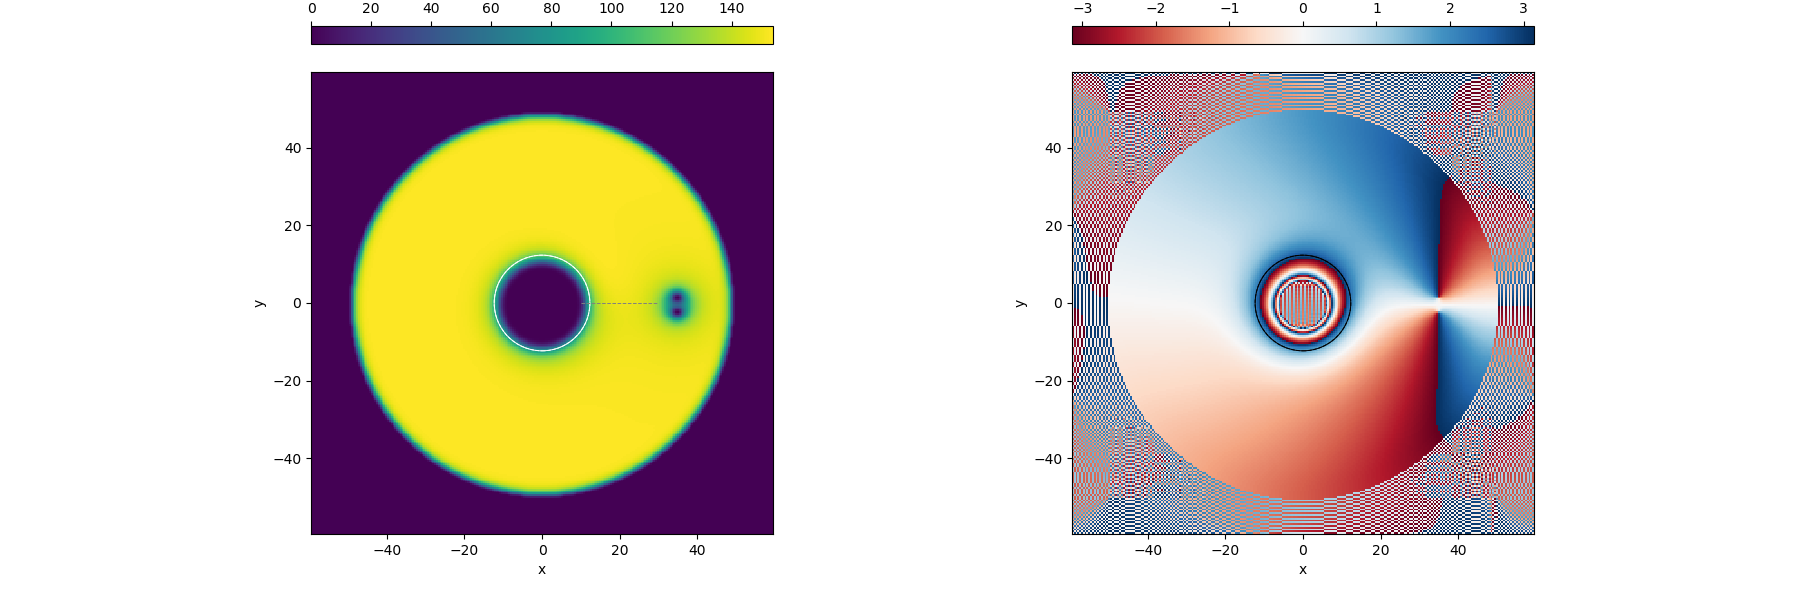

<IPython.core.display.Javascript object>


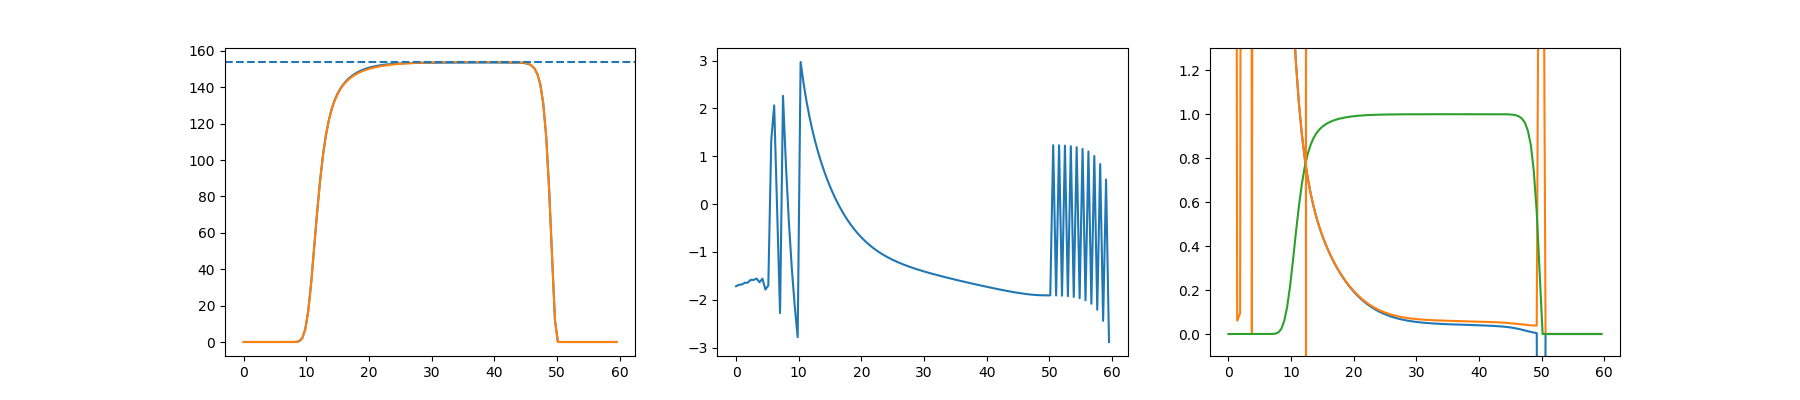

12.320909364072094 12.32277417455297
500


In [28]:
# with open(root / 'configure.yaml', 'r') as f:
#     conf = yaml.safe_load(f)
# globs = conf['globals']


# with h5py.File(h5filename, 'r') as f:
#     conf = dict(f['configure'].attrs)
#     globs = dict(f['configure/globals'].attrs)

# alpha = globs['alpha']
# nu = globs['nu']
# radius = globs['radius']
# Gamma = globs['Gamma']
# mu = globs['mu'] if 'mu' in globs else 1



with h5py.File(h5filename, 'r') as f:
#     g = f[f"groundstate/1"]
#     g = f[f"realtime/1"]
    g = f[f"1"]
    x = g['x'][:]
    y = g['y'][:]
    psiI = g['psiI'][:]
    psiR = g['psiR'][:]   
    
#     n0 = f['groundstate/1/psiI'][:]**2 + f['groundstate/1/psiR'][:]**2
# norm = np.sum(psiR**2 + psiI**2, axis=(1, 2))

# psiR = psiR[-1]
# psiI = psiI[-1]
    
L = len(x) // 2

r = x[L:]

# radial_slice = np.index_exp[L:0:-1, L]
radial_slice = np.index_exp[L, L:]

extent = (x.min(), x.max(), y.max(), y.min())

psi = psiR + 1j * psiI
density = psiR**2 + psiI**2
_phase = np.arctan2(psiI, psiR)

X, Y = np.meshgrid(x, y, indexing='ij')
R = np.hypot(X, Y)
phi = np.arctan2(Y, X)

# _phase[density < 0.1] = 0

phase = unwrap_phase(_phase)

phase[R > radius] = 0



c = np.sqrt(alpha * density)

fig, (ax, ax_p) = plot2d(density, _phase)
ax.hlines([0], 10, 30, colors='gray', linestyles='--', linewidths=0.7)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

# ax1.imshow(phase, cmap='RdBu', vmin=-np.pi, vmax=np.pi)
ax1.plot(r, density[radial_slice])
ax1.plot(r, n0[radial_slice])
ax1.axhline(mu/alpha, ls='--')

ax2.plot(r, _phase[radial_slice])
# ax2.plot(r, p0[radial_slice])

vx, vy = np.gradient(np.sqrt(2) * phase, x, y)
v = np.hypot(vx, vy)

vr = np.cos(phi) * vx + np.sin(phi) * vy
v_phi = -np.sin(phi) * vx + np.cos(phi) * vy

r1, r2 = 8, 30
ax3.plot(r, np.where(r < r1, np.nan, -vr[radial_slice]), '-')
ax3.plot(r, v[radial_slice])

ax3.plot(r, c[radial_slice])



wh = (r >= r1) & (r <= r2)

f = interp1d(r[wh], (-vr - c)[radial_slice][wh], fill_value='extrapolate')
rh = brentq(f, r1, r2)

f = interp1d(r[wh], (v - c)[radial_slice][wh], fill_value='extrapolate')
re = brentq(f, r1, r2)

print(rh, re)


ax.add_patch(Ellipse((0, 0), 2*rh, 2*rh, fc='none', ec='w', lw=0.7))
ax.add_patch(Ellipse((0, 0), 2*re, 2*re, fc='none', ec='w', lw=0.7, ls='--'))

ax_p.add_patch(Ellipse((0, 0), 2*rh, 2*rh, fc='none', ec='k', lw=0.7))
ax_p.add_patch(Ellipse((0, 0), 2*re, 2*re, fc='none', ec='k', lw=0.7, ls='--'))

ax3.axvline(rh, color='C0')
ax3.axvline(re, color='C1')

# ax3.set_xlim(None, 30)
ax3.set_ylim(-0.1, 1.3)

print(Gamma)

In [17]:
sec = 10300
m, s = divmod(sec, 60)
h, m = divmod(m, 60)
print(h, m, s)

2 51 40


In [18]:
np.all(X == Xu)

NameError: name 'Xu' is not defined

In [ ]:
print(len(x))

In [260]:
conf

{'build_dir': 'build',
 'dt': 1e-06,
 'h5filepath': '{sequence_index:04d}/bh_{run_number:04d}.h5',
 'run_dir': 'run'}

In [261]:
globs

{'Gamma': 20,
 'Lambda': 0.3,
 'U0': 10000,
 'Ue': 0.75,
 'alpha': 0.0065,
 'cx': 17,
 'cy': 0,
 'nu': 10,
 'radius': 50,
 'sigma': 3,
 'sx': 5,
 'sy': 1}

In [262]:
globs

{'Gamma': 20,
 'Lambda': 0.3,
 'U0': 10000,
 'Ue': 0.75,
 'alpha': 0.0065,
 'cx': 17,
 'cy': 0,
 'nu': 10,
 'radius': 50,
 'sigma': 3,
 'sx': 5,
 'sy': 1}

In [263]:
plt.imshow(_phase)

In [264]:
def gs_wavefunction(x, y, zeta, nu, alpha, r0=1, phi0=0):
    r = np.hypot(x, y)
    rmin = np.hypot(zeta, nu)
    phi = np.arctan2(y, x)
#     phase = np.where(r > rmin, -zeta * np.log(r / r0) + nu * phi + phi0, 0)
    phase = -zeta * np.log(r / r0) + nu * phi + phi0
    psi = np.sqrt(1 / alpha) * np.maximum(0, 1 - rmin**2 / r**2) * np.exp(1j * phase)
    return psi

In [265]:
M = lmfit.Model(gs_wavefunction, independent_vars=['x', 'y'])

    
M.set_param_hint('zeta', min=0)
M.set_param_hint('nu', vary=False, value=nu)
M.set_param_hint('r0', vary=False, value=1)
M.set_param_hint('alpha', min=0)
M.set_param_hint('phi0', min=-np.pi, max=np.pi, vary=False, value=0)

p0 = M.make_params(zeta=3, r0=1, phi0=0, alpha=alpha)

wh = (R > 7.5) & (R < 15)

res = M.fit(psi[wh], p0, x=X[wh], y=Y[wh])

In [266]:
zeta = res.params['zeta'].value

res.params

Parameters([('zeta',
             <Parameter 'zeta', value=3.061946583650842 +/- 2.07, bounds=[0:inf]>),
            ('nu', <Parameter 'nu', value=10 (fixed), bounds=[-inf:inf]>),
            ('alpha',
             <Parameter 'alpha', value=180.75914428637364 +/- 1.84e+03, bounds=[0:inf]>),
            ('phi0',
             <Parameter 'phi0', value=0 (fixed), bounds=[-3.141592653589793:3.141592653589793]>),
            ('r0', <Parameter 'r0', value=1 (fixed), bounds=[-inf:inf]>)])

In [267]:
vx, vy = np.gradient(np.sqrt(2) * phase, x, y)



v = np.hypot(vx, vy)

# mask = v > 9
# vx[mask] = 0
# vy[mask] = 0
# v[mask] = 0

vr = np.cos(phi) * vx + np.sin(phi) * vy
v_phi = -np.sin(phi) * vx + np.cos(phi) * vy



In [268]:
psiI.shape

(256, 256)

In [269]:
%matplotlib inline

In [270]:
v.min()

0.0

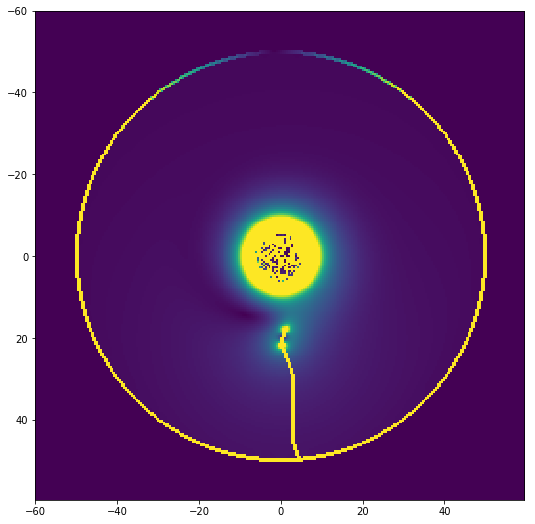

In [271]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.imshow(v, extent=extent, vmax=2)

In [80]:
%matplotlib notebook

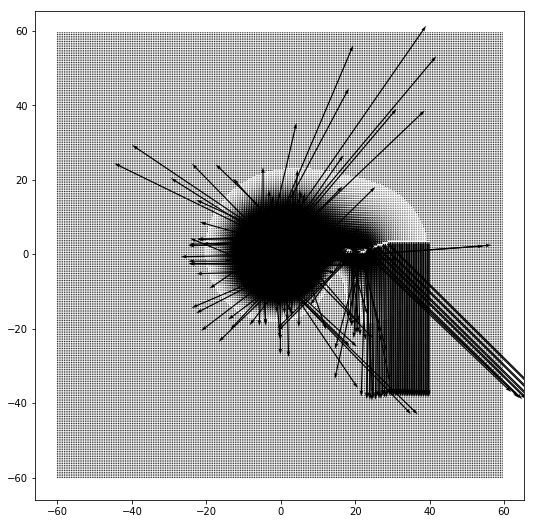

In [272]:
rmin, rmax = 5, 40
mask = (R < rmin) | (R > rmax)

_vx = np.where(mask, 0, vx)
_vy = np.where(mask, 0, vy)

fig, ax = plt.subplots(figsize=(9, 9))
plt.quiver(X, Y, _vx, _vy, angles='xy', scale=60)
ax.set_aspect(1)
# ax.set(xlim=(-10, 10), ylim=(5, 30))

In [273]:
from scipy.optimize import brentq
from scipy.interpolate import interp1d

In [274]:
zeta

3.061946583650842

/home/carmelo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


(-0.3, 5)

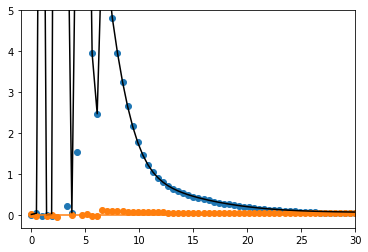

In [278]:
plt.plot(r, -vr[radial_slice], 'o')
plt.plot(r, v_phi[radial_slice], 'o')
plt.plot(r, v[radial_slice], 'k-')

# plt.plot(r, np.sqrt(2) * 3 / r, 'C0')
# plt.plot(r, np.sqrt(2) * 1 / r, 'C0')
plt.plot(r, np.sqrt(2) * nu / r, 'C1')

plt.xlim(-1, 30)
plt.ylim(-0.3, 5)

In [276]:
nu

10

In [112]:
(1 + np.sqrt(3)) / np.sqrt(2)

1.9318516525781364

12.350109329752115 17.737201636859847
12.349433014465864 19.968116404440106


(-0.1, 1.3)

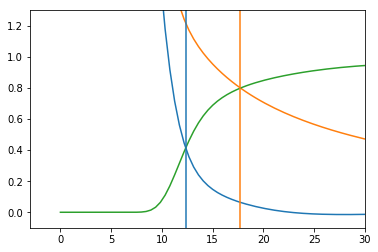

In [174]:
fig, ax3 = plt.subplots()

r1, r2 = 8, rmax
ax3.plot(r, np.where(r < r1, np.nan, -vr[radial_slice]), '-')
ax3.plot(r, v[radial_slice])

ax3.plot(r, c[radial_slice])



wh = (r >= r1) & (r <= r2)

f = interp1d(r[wh], (-vr - c)[radial_slice][wh], fill_value='extrapolate')
rh = brentq(f, r1, r2)

f = interp1d(r[wh], (v - c)[radial_slice][wh], fill_value='extrapolate')
re = brentq(f, r1, r2)

print(rh, re)

# rh1 = (zeta + np.sqrt(3*zeta**2 + 2*nu**2)) / np.sqrt(2)
# re1 = (1 + np.sqrt(3)) * np.sqrt((zeta**2 + nu**2) / 2)
# print(rh1, re1)

ax3.axvline(rh, color='C0')
# ax3.axvline(rh1, color='C0', ls='--')

ax3.axvline(re, color='C1')
# ax3.axvline(re1, color='C1', ls='--')

ax3.set_xlim(None, 30)
ax3.set_ylim(-0.1, 1.3)

In [114]:
1/1.4

0.7142857142857143

In [115]:
def zeta_nu(rh, re):
    x = 2 * re**2 / (1 + np.sqrt(3))**2
    zeta = (rh - x / rh) / np.sqrt(2)
    nu = np.sqrt(x - zeta**2)
    return zeta, nu

zeta_nu(rh, re)

(0.9749423379716806, 9.066309066709502)

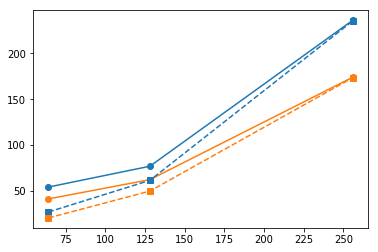

In [29]:
n = [64, 128, 256]
time_openmp = np.asarray([54.32, 77, 236])
time_mpi = np.asarray([41.43, 62.4, 174])
failed = np.asarray([50, 20, 0.3]) / 100

fig, ax = plt.subplots()
ax.plot(n, time_openmp, 'o-')
ax.plot(n, time_mpi, 'o-')

ax.set_prop_cycle(None)
ax.plot(n, time_openmp * (1 - failed), 's--')
ax.plot(n, time_mpi * (1 - failed), 's--')

# ax.set_xscale('log')